In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data'
figDir = '/home/chantal/Chazy/Bulk/515_806/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'
#physeqBulk = 'bulk-core' 

#l2fcResFile = file.path(workDir, 'l2fc_sparse-maxRejH_BULK_0.25_.txt')
## NOTEBOOK RUN WITH 0.25 SPARSITY FILTERED DATASET...

nprocs = 20

In [3]:
%%R
library(ggplot2)
library(phyloseq)
library(gridExtra)
library(data.table)
library(vegan)
library(plyr);library(dplyr)
library(tidyr)
library(picante)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is vegan 2.3-3

  res =

In [4]:
%%R

##Importing and pruning physeq object

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)


physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [6]:
%%R

physeq.sparse = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.sparse

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3964 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3964 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3964 tips and 3963 internal nodes ]


In [7]:
%%R
#Creating dataframe from physeq object
mdf = psmelt(physeq.sparse)

In [8]:
%%R 
#Importing phylogenetic tree
phy = read.tree('otusn_pick_sparse.tree')
#plot(phy, cex = 0.5)

## Calculating NRI (SES - to get NRI, multiply z values by -1)

In [9]:
%%R
df.l2fc.OM = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep = '\t', header = TRUE)
head(df.l2fc.OM)

  sparsity_threshold       OTU log2FoldChange     lfcSE       padj    Rank1
1               0.25  OTU.1739    -0.99492092 0.3368987 0.03078444 Bacteria
2               0.25  OTU.1813    -0.34779469 0.3307678 0.55980382 Bacteria
3               0.25   OTU.778     0.08123953 0.1389644 0.77642167 Bacteria
4               0.25  OTU.2180     0.01465938 0.2546136 0.98421287 Bacteria
5               0.25 OTU.12365    -0.52013058 0.2320783 0.12348165 Bacteria
6               0.25  OTU.2343    -0.66780501 0.2743011 0.08786400 Bacteria
             Rank2          Rank3                  Rank4 Rank5 Rank6 Rank7
1 __Planctomycetes        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>
2 __Planctomycetes        __OM190 __uncultured_bacterium  <NA>  <NA>  <NA>
3 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
4 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
5 __Planctomycetes __Pla4_lineage __uncultured_bacterium  <NA>  <NA>  <NA>
6 __Planctomycetes

In [10]:
%%R
H.l2fc = filter(df.l2fc.OM, padj2 <=0.10, OM == 'Harvested')
R.l2fc = filter(df.l2fc.OM, padj2 <=0.10, OM == 'Returned')

In [11]:
%%R
head(mdf)
H = filter(mdf, OTU %in% H.l2fc$OTU)
R = filter(mdf, OTU %in% R.l2fc$OTU)

In [12]:
%%R
print(length(unique(H$OTU)))
print(length(unique(R$OTU)))


[1] 137
[1] 99


In [13]:
%%R
OTUs.H = H %>% select(OTU, Sample, Abundance) %>% spread(OTU, Abundance)

OTUs.R = R %>% select(OTU, Sample, Abundance) %>% spread(OTU, Abundance)

In [28]:
%%R
nrow(OTUs.H)

[1] 175


In [29]:
%%R
#Setting OTUs as rownames
rownames(OTUs.H) = OTUs.H$Sample
OTUs.H$Sample = NULL

rownames(OTUs.R) = OTUs.R$Sample
OTUs.R$Sample = NULL

In [30]:
%%R
#Normalizing OTU counts 
comm.H <- decostand(OTUs.H, method = "total")

comm.R <- decostand(OTUs.R, method = "total")

In [32]:
%%R
head(comm.H)
#Calculate LFC with R1 till vs R1 no-till with time being replicate (n = 11). Then use NRI or NTI with replicates...
# If autocorrelation w time, underrepresenting variance; compare responders w global set 

                 OTU.1031     OTU.1035    OTU.1069 OTU.11057     OTU.1118
April15.NTH.1 0.003517588 0.0010050251 0.000000000         0 0.0005025126
April15.NTH.2 0.001101322 0.0005506608 0.000000000         0 0.0027533040
April15.NTH.3 0.000000000 0.0000000000 0.000000000         0 0.0025813113
April15.NTH.4 0.002416432 0.0016109545 0.004027386         0 0.0016109545
April15.NTR.1 0.003445306 0.0017226529 0.000000000         0 0.0025839793
April15.NTR.2 0.004016064 0.0013386881 0.000000000         0 0.0026773762
                  OTU.1142   OTU.11497    OTU.11653     OTU.1170    OTU.1183
April15.NTH.1 0.0000000000 0.021608040 0.0005025126 0.0045226131 0.016582915
April15.NTH.2 0.0000000000 0.003854626 0.0011013216 0.0027533040 0.008810573
April15.NTH.3 0.0015487868 0.002065049 0.0020650490 0.0036138358 0.006195147
April15.NTH.4 0.0004027386 0.008860250 0.0112766814 0.0008054772 0.006846557
April15.NTR.1 0.0000000000 0.006890612 0.0034453058 0.0060292851 0.012919897
April15.NTR.2 0.0000

In [14]:
%%R
tree = as.phylo(phy)

In [ ]:
%%R
# For NRI, create 2 comm files - one for NT and one for PT...but use whole tree for both
nri.H = ses.mpd(comm.H,cophenetic(tree),null.model="taxa.labels",runs=1000)


In [ ]:
%%R 
write.csv(nri.H, file = 'data/NRI_H_all.csv')
nri.H = 0 

In [4]:
%%R
NRI_H = read.csv('data/NRI_H_all.csv')
NRI_H$padj = p.adjust(NRI_H$mpd.obs.p,"BH")
head(NRI_H)
summary(NRI_H)

             X           ntaxa          mpd.obs       mpd.rand.mean   
 April15.NTH.1:  1   Min.   : 55.0   Min.   :0.6713   Min.   :0.7854  
 April15.NTH.2:  1   1st Qu.: 91.0   1st Qu.:0.6997   1st Qu.:0.7860  
 April15.NTH.3:  1   Median :103.0   Median :0.7069   Median :0.7863  
 April15.NTH.4:  1   Mean   :101.1   Mean   :0.7051   Mean   :0.7863  
 April15.NTR.1:  1   3rd Qu.:113.0   3rd Qu.:0.7128   3rd Qu.:0.7866  
 April15.NTR.2:  1   Max.   :128.0   Max.   :0.7292   Max.   :0.7873  
 (Other)      :169                                                    
  mpd.rand.sd       mpd.obs.rank      mpd.obs.z        mpd.obs.p       
 Min.   :0.02315   Min.   : 1.000   Min.   :-4.380   Min.   :0.000999  
 1st Qu.:0.02440   1st Qu.: 1.000   1st Qu.:-3.313   1st Qu.:0.000999  
 Median :0.02569   Median : 2.000   Median :-3.072   Median :0.001998  
 Mean   :0.02638   Mean   : 3.097   Mean   :-3.086   Mean   :0.003094  
 3rd Qu.:0.02768   3rd Qu.: 3.500   3rd Qu.:-2.878   3rd Qu.:0.003497  


In [5]:
%%R
NRI_H$treat = 'H'
head(NRI_H)

              X ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank
1 April15.NTH.1   119 0.7077917     0.7860068  0.02412908            2
2 April15.NTH.2   122 0.7110567     0.7863630  0.02371607            1
3 April15.NTH.3   112 0.6966404     0.7865866  0.02445917            1
4 April15.NTH.4   122 0.7073601     0.7861038  0.02386394            2
5 April15.NTR.1    94 0.7140708     0.7862735  0.02694968            5
6 April15.NTR.2    74 0.7223808     0.7867458  0.03048246           16
  mpd.obs.z   mpd.obs.p runs        padj treat
1 -3.241528 0.001998002 1000 0.003567861     H
2 -3.175326 0.000999001 1000 0.002775003     H
3 -3.677403 0.000999001 1000 0.002775003     H
4 -3.299692 0.001998002 1000 0.003567861     H
5 -2.679165 0.004995005 1000 0.005463287     H
6 -2.111542 0.015984016 1000 0.016262807     H


In [ ]:
%%R
nri.R = ses.mpd(comm.R,cophenetic(tree),null.model="taxa.labels", runs = 1000)


In [ ]:
%%R
write.csv(nri.R, file = 'data/NRI_R_all.csv')
nri.R = 0 

In [6]:
%%R
NRI_R = read.csv('data/NRI_R_all.csv')
NRI_R$padj = p.adjust(NRI_R$mpd.obs.p,"BH")
head(NRI_R)
summary(NRI_R)

             X           ntaxa          mpd.obs       mpd.rand.mean   
 April15.NTH.1:  1   Min.   :46.00   Min.   :0.6713   Min.   :0.7839  
 April15.NTH.2:  1   1st Qu.:62.00   1st Qu.:0.7085   1st Qu.:0.7857  
 April15.NTH.3:  1   Median :70.00   Median :0.7179   Median :0.7861  
 April15.NTH.4:  1   Mean   :71.09   Mean   :0.7167   Mean   :0.7861  
 April15.NTR.1:  1   3rd Qu.:80.00   3rd Qu.:0.7270   3rd Qu.:0.7864  
 April15.NTR.2:  1   Max.   :96.00   Max.   :0.7446   Max.   :0.7876  
 (Other)      :169                                                    
  mpd.rand.sd       mpd.obs.rank     mpd.obs.z        mpd.obs.p       
 Min.   :0.02646   Min.   : 1.00   Min.   :-3.257   Min.   :0.000999  
 1st Qu.:0.02889   1st Qu.: 7.00   1st Qu.:-2.471   1st Qu.:0.006993  
 Median :0.03122   Median :12.00   Median :-2.194   Median :0.011988  
 Mean   :0.03118   Mean   :16.44   Mean   :-2.224   Mean   :0.016424  
 3rd Qu.:0.03322   3rd Qu.:22.00   3rd Qu.:-1.977   3rd Qu.:0.021978  
 Max. 

In [7]:
%%R
NRI_R$treat = 'R'
head(NRI_R)

              X ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank
1 April15.NTH.1    72 0.7284814     0.7862350  0.03092315           29
2 April15.NTH.2    71 0.7173365     0.7864960  0.03064993           11
3 April15.NTH.3    68 0.7275946     0.7857646  0.03149121           35
4 April15.NTH.4    68 0.7163322     0.7845636  0.03221450           13
5 April15.NTR.1    92 0.7256701     0.7865319  0.02684672           11
6 April15.NTR.2    79 0.7252887     0.7856717  0.02935857           19
  mpd.obs.z  mpd.obs.p runs       padj treat
1 -1.867649 0.02897103 1000 0.03448932     R
2 -2.256430 0.01098901 1000 0.02280328     R
3 -1.847183 0.03496503 1000 0.03848353     R
4 -2.118035 0.01298701 1000 0.02367424     R
5 -2.267013 0.01098901 1000 0.02280328     R
6 -2.056742 0.01898102 1000 0.02657343     R


In [8]:
%%R
NRI_tot = rbind(NRI_H, NRI_R)
head(NRI_tot)

              X ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank
1 April15.NTH.1   119 0.7077917     0.7860068  0.02412908            2
2 April15.NTH.2   122 0.7110567     0.7863630  0.02371607            1
3 April15.NTH.3   112 0.6966404     0.7865866  0.02445917            1
4 April15.NTH.4   122 0.7073601     0.7861038  0.02386394            2
5 April15.NTR.1    94 0.7140708     0.7862735  0.02694968            5
6 April15.NTR.2    74 0.7223808     0.7867458  0.03048246           16
  mpd.obs.z   mpd.obs.p runs        padj treat
1 -3.241528 0.001998002 1000 0.003567861     H
2 -3.175326 0.000999001 1000 0.002775003     H
3 -3.677403 0.000999001 1000 0.002775003     H
4 -3.299692 0.001998002 1000 0.003567861     H
5 -2.679165 0.004995005 1000 0.005463287     H
6 -2.111542 0.015984016 1000 0.016262807     H


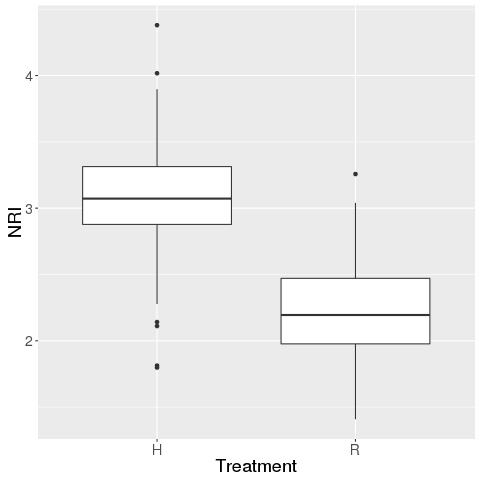

In [9]:
%%R
ggplot(data = NRI_tot, aes(x = treat, y = -mpd.obs.z)) +
geom_boxplot() + theme(text = element_text(size = 18)) + xlab('Treatment') + ylab('NRI')

In [10]:
%%R
t.test(NRI_tot$mpd.obs.z ~ NRI_tot$treat)


	Welch Two Sample t-test

data:  NRI_tot$mpd.obs.z by NRI_tot$treat
t = -21.868, df = 346.94, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9397707 -0.7846712
sample estimates:
mean in group H mean in group R 
      -3.086396       -2.224176 



## Calculating NTI (SES, multiply z-values by -1 to get NTI)

In [ ]:
%%R
nti.H = ses.mntd(comm.H,cophenetic(tree),null.model="taxa.labels",runs=1000)


In [ ]:
%%R
write.csv(nti.H, file = 'data/NTI_H_all.csv')
nti.H = 0 

In [11]:
%%R
NTI_H = read.csv('data/NTI_H_all.csv')
NTI_H$padj = p.adjust(NTI_H$mntd.obs.p,"BH")

summary(NTI_H)

             X           ntaxa          mntd.obs      mntd.rand.mean  
 April15.NTH.1:  1   Min.   : 55.0   Min.   :0.1516   Min.   :0.2304  
 April15.NTH.2:  1   1st Qu.: 91.0   1st Qu.:0.1721   1st Qu.:0.2415  
 April15.NTH.3:  1   Median :103.0   Median :0.1809   Median :0.2497  
 April15.NTH.4:  1   Mean   :101.1   Mean   :0.1824   Mean   :0.2537  
 April15.NTR.1:  1   3rd Qu.:113.0   3rd Qu.:0.1889   3rd Qu.:0.2623  
 April15.NTR.2:  1   Max.   :128.0   Max.   :0.2390   Max.   :0.3150  
 (Other)      :169                                                    
  mntd.rand.sd     mntd.obs.rank      mntd.obs.z       mntd.obs.p      
 Min.   :0.01443   Min.   : 1.000   Min.   :-5.649   Min.   :0.000999  
 1st Qu.:0.01609   1st Qu.: 1.000   1st Qu.:-4.410   1st Qu.:0.000999  
 Median :0.01718   Median : 1.000   Median :-4.042   Median :0.000999  
 Mean   :0.01782   Mean   : 1.297   Mean   :-4.013   Mean   :0.001296  
 3rd Qu.:0.01905   3rd Qu.: 1.000   3rd Qu.:-3.607   3rd Qu.:0.000999  


In [ ]:
%%R
nti.R = ses.mntd(comm.R,cophenetic(tree),null.model="taxa.labels",runs=1000)


In [ ]:
%%R
write.csv(nti.R, file = 'data/NTI_R_all.csv')
nti.R = 0 

In [12]:
%%R
NTI.R = read.csv('data/NTI_R_all.csv', header = TRUE)
NTI.R$padj = p.adjust(NTI.R$mntd.obs.p,"BH")

head(NTI.R)

              X ntaxa  mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank
1 April15.NTH.1    72 0.2017658      0.2863493   0.02294299             1
2 April15.NTH.2    71 0.2343228      0.2870841   0.02335602            10
3 April15.NTH.3    68 0.2156374      0.2924221   0.02340951             1
4 April15.NTH.4    68 0.2071612      0.2915234   0.02401987             1
5 April15.NTR.1    92 0.1844709      0.2612486   0.01879674             1
6 April15.NTR.2    79 0.2081582      0.2766268   0.02118300             2
  mntd.obs.z  mntd.obs.p runs        padj
1  -3.686683 0.000999001 1000 0.001942502
2  -2.259002 0.009990010 1000 0.010406260
3  -3.280067 0.000999001 1000 0.001942502
4  -3.512186 0.000999001 1000 0.001942502
5  -4.084628 0.000999001 1000 0.001942502
6  -3.232240 0.001998002 1000 0.002963139


In [ ]:
%%R
summary(NTI.R)

In [13]:
%%R
NTI_H$treat = 'H'
NTI.R$treat = 'R'


In [14]:
%%R
NTI_tot = rbind(NTI_H, NTI.R)
head(NTI_tot)

              X ntaxa  mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank
1 April15.NTH.1   119 0.1601981      0.2363847   0.01530298             1
2 April15.NTH.2   122 0.1639843      0.2344501   0.01525329             1
3 April15.NTH.3   112 0.1711293      0.2425792   0.01634211             1
4 April15.NTH.4   122 0.1606225      0.2345589   0.01517529             1
5 April15.NTR.1    94 0.1907659      0.2590061   0.01851781             1
6 April15.NTR.2    74 0.2280904      0.2828609   0.02231277             6
  mntd.obs.z  mntd.obs.p runs        padj treat
1  -4.978550 0.000999001 1000 0.001085871     H
2  -4.619715 0.000999001 1000 0.001085871     H
3  -4.372134 0.000999001 1000 0.001085871     H
4  -4.872154 0.000999001 1000 0.001085871     H
5  -3.685113 0.000999001 1000 0.001085871     H
6  -2.454670 0.005994006 1000 0.006063301     H


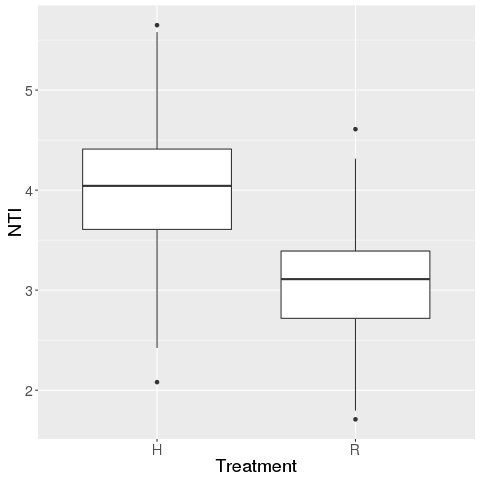

In [15]:
%%R
ggplot(data = NTI_tot, aes(x = treat, y = -mntd.obs.z)) +
geom_boxplot() + theme(text = element_text(size = 18)) + xlab('Treatment') + ylab('NTI')

In [16]:
%%R
t.test(NTI_tot$mntd.obs.z ~ NTI_tot$treat)


	Welch Two Sample t-test

data:  NTI_tot$mntd.obs.z by NTI_tot$treat
t = -16.247, df = 336.98, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.044399 -0.818819
sample estimates:
mean in group H mean in group R 
      -4.013380       -3.081771 



## Global NRI/NTI

In [15]:
%%R
H$Replicate[is.na(H$Replicate)] = 3

H2 = H %>% group_by(Replicate, OTU) %>% summarise(totalab = sum(Abundance))
H2$Comm = 'H'
head(H2)

Source: local data frame [6 x 4]
Groups: Replicate [1]

  Replicate       OTU totalab  Comm
      (dbl)     (chr)   (dbl) (chr)
1         1  OTU.1031      99     H
2         1  OTU.1035     110     H
3         1  OTU.1069      22     H
4         1 OTU.11057      81     H
5         1  OTU.1118      72     H
6         1  OTU.1142      55     H


In [16]:
%%R
R$Replicate[is.na(R$Replicate)] = 3

R2 = R %>% group_by(Replicate, OTU) %>% summarise(totalab = sum(Abundance))
R2$Comm = 'H'
head(R2)

Source: local data frame [6 x 4]
Groups: Replicate [1]

  Replicate      OTU totalab  Comm
      (dbl)    (chr)   (dbl) (chr)
1         1  OTU.102    1232     H
2         1 OTU.1140     190     H
3         1 OTU.1167      41     H
4         1 OTU.1215      54     H
5         1 OTU.1232     114     H
6         1  OTU.131     630     H


In [17]:
%%R
OTUs.H = H2 %>% select(OTU, Replicate, totalab) %>% spread(OTU, totalab)

OTUs.R = R2 %>% select(OTU, Replicate, totalab) %>% spread(OTU, totalab)

In [18]:
%%R
rownames(OTUs.H) = OTUs.H$Replicate
OTUs.H$Replicate = NULL

rownames(OTUs.R) = OTUs.R$Replicate
OTUs.R$Replicate = NULL

In [19]:
%%R
#Normalizing OTU counts 
comm.H <- decostand(OTUs.H, method = "total")

comm.R <- decostand(OTUs.R, method = "total")

In [23]:
%%R
nrow(comm.R)

[1] 4


In [24]:
%%R
nri.H.global = ses.mpd(comm.H,cophenetic(tree),null.model="taxa.labels",runs=1000)
nri.H.global

  ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank mpd.obs.z   mpd.obs.p
1   137 0.6167982      0.724951  0.02226718            1 -4.857049 0.000999001
2   137 0.6167982      0.724951  0.02226718            1 -4.857049 0.000999001
3   137 0.6167982      0.724951  0.02226718            1 -4.857049 0.000999001
4   137 0.6167982      0.724951  0.02226718            1 -4.857049 0.000999001
  runs
1 1000
2 1000
3 1000
4 1000


In [33]:
%%R
write.csv(nri.H.global, 'data/nri_H_global.csv')

In [25]:
%%R
nri.R.global = ses.mpd(comm.R,cophenetic(tree),null.model="taxa.labels",runs=1000)
nri.R.global

  ntaxa  mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank mpd.obs.z  mpd.obs.p
1    99 0.671839     0.7249839  0.02588409           25 -2.053187 0.02497502
2    99 0.671839     0.7249839  0.02588409           25 -2.053187 0.02497502
3    99 0.671839     0.7249839  0.02588409           25 -2.053187 0.02497502
4    99 0.671839     0.7249839  0.02588409           25 -2.053187 0.02497502
  runs
1 1000
2 1000
3 1000
4 1000


In [32]:
%%R
write.csv(nri.R.global, 'data/nri_R_global.csv')

In [30]:
%%R
nti.H.global = ses.mntd(comm.H,cophenetic(tree),null.model="taxa.labels",runs=1000)
nti.H.global

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in `colnames<-`(`*tmp*`, value = c("OTU.16296", "OTU.1325", "OTU.2929",  : 
  Interrupted

  res = super(Function, self).__call__(*new_args, **new_kwargs)


KeyboardInterrupt: 

In [29]:
%%R
write.csv(nti.H.global, 'data/nti_H_global.csv')

In [27]:
%%R
nti.R.global = ses.mntd(comm.R,cophenetic(tree),null.model="taxa.labels",runs=1000)
nti.R.global

  ntaxa  mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank mntd.obs.z
1    99 0.1666755      0.2161147   0.01484671             1  -3.329983
2    99 0.1666755      0.2161147   0.01484671             1  -3.329983
3    99 0.1666755      0.2161147   0.01484671             1  -3.329983
4    99 0.1666755      0.2161147   0.01484671             1  -3.329983
   mntd.obs.p runs
1 0.000999001 1000
2 0.000999001 1000
3 0.000999001 1000
4 0.000999001 1000


In [28]:
%%R
write.csv(nti.R.global, 'data/nti_R_global.csv')